# **Predicting price deviations in the Chilean energy industry**

After the cost of the energy is forecasted in the Chilean industry, later, this is compared with the actual cost to monitor how close from each other they are. To monitor this, the percentage of deviation of the forecasted cost with respect to the actual cost is computed. Specifically, it is important to detect those deviation greater than 15%. Then, the goal of this problem is to predict whether the energy costs will deviate more than 15% or not, which is a classification problem

# Index

The first part prepares the data to be analyzed

1. [Data Exploration and Cleaning](#cell-1.)
2. [Feature Engineering](#cell-2.)
3. [Visualization](#cell-3.)
4. [Adding possible useful variables](#cell-4.)
5. [Model](#cell-5.)




Import libraries

In [ ]:
import pandas as pd # data manipulation

import numpy as np # data manipulation
import matplotlib.pyplot as plt # visualization
import math # general math
import xgboost as xgb # ML Technique here used
from xgboost import plot_importance, plot_tree # Model interpretation
from sklearn.metrics import confusion_matrix # Tools for ML
from sklearn.metrics import mean_squared_error, mean_absolute_error # Tools for ML
# for showing dinamic tables 
%load_ext google.colab.data_table # make tables beautiful


<a name="cell-1."></a>
# **1. Data Exploration**


**1.1 Upload and merge data**





In [ ]:
# A) Upload data

# invoke a file selector (select the files)
from google.colab import files

uploaded = files.upload()

# iterate the uploaded files in order to find their key names
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving costo_marginal_real.csv to costo_marginal_real.csv
User uploaded file "costo_marginal_real.csv" with length 390673661 bytes


**About the variables:**
- sub ID of the energy station from where the energy comes from: barra_mnemotecnico: 
- ID of the energy station from where the energy comes from: barra_referencia_mnemotecnico
- date: fecha
- time: hora
- cost in dolars: costo_en_dolares
- cost in another currency: costo_en_pesos
- name of the energy station: nombre
- actual cost: costo_real
- forecasted cost: costo_programado

In [ ]:
costo_real = pd.read_csv('costo_marginal_real.csv')
costo_real.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


In [ ]:
costo_programado = pd.read_csv('costo_marginal_programado.csv')
costo_programado.head()

,mnemotecnico_barra,nombre_barra,fecha,hora,costo
0,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,1.0,49.897334
1,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,2.0,50.471616
2,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,3.0,50.077821
3,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,4.0,49.796216
4,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,5.0,49.796216


In [ ]:
# B) Merge costos reales (real costs) and costos programados (forecasted costs)

# change 'fecha' data type to to_datetime data type
costo_real['fecha'] = pd.to_datetime(costo_real['fecha']) 
costo_programado['fecha'] = pd.to_datetime(costo_programado['fecha']) # change 'fecha' data type to to_datetime data type

# rename columns to later make the merge
costo_programado.rename(columns={'mnemotecnico_barra':'barra_mnemotecnico','nombre_barra':'nombre'}, inplace=True)

# merge
costo_marginal = pd.merge(costo_real,costo_programado,on=['barra_mnemotecnico','nombre','fecha','hora'])
costo_marginal = costo_marginal.drop(['costo_en_pesos'],1) # drop redundant variable

# rename with appropriate variable names
costo_marginal.rename(columns={'costo_en_dolares':'costo_real','costo':'costo_programado'}, inplace=True)
costo_marginal.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_real,nombre,costo_programado
0,BA01G021SE018G021,BA02T002SE032T002,2019-04-06,25,58.02,BA S/E CENTRAL QUINTERO 220KV,54.292145
1,BA01T018SE001T018,BA02T002SE032T002,2019-04-06,25,63.60,BA S/E NUEVA PICHIRROPULLI 220KV B1,60.620648
2,BA02T005SE055T005,BA02T002SE032T002,2019-04-06,25,62.78,BA S/E SAN FRANCISCO DE MOSTAZAL 66KV T1,59.177969
3,BA01T002SE029T002,BA02T002SE032T002,2019-04-06,25,58.55,BA S/E CENTRAL PEHUENCHE 220KV B1,54.566605
4,BA01R002SE041R002,BA02T002SE032T002,2019-04-06,25,60.39,BA S/E SAN CRISTOBAL 110KV B1,56.086260


**1.2. Exploratory analysis**

In [ ]:
# A) check for duplicated data
duplicated = costo_marginal[costo_marginal.duplicated(subset=['barra_mnemotecnico','nombre','fecha','hora'], keep=False)] # create a df only with the duplicates
# percentage of duplicated data
percentage_duplicated = round(100 * ((len(duplicated.index))/2) / len(costo_marginal.index),2)
print(percentage_duplicated,'% of the data are duplicates')

1.36 % of the data are duplicates


**Observations:**
- Duplicates: there are costs that were forecasted two times (here are observations with the same ID but different forecasted costs)
- 1.36% of the data are duplicates

In [ ]:
# Analyse duplicated data

duplicates_analysis = duplicated.drop(['Unnamed: 0'],1) # an unnesessary column was created, so, drop it
# Put duplicates in a column so that it can be compared
duplicates_analysis = duplicated.join(duplicates_analysis.groupby(['barra_mnemotecnico','nombre','fecha','hora']).last(), on=['barra_mnemotecnico','nombre','fecha','hora'], rsuffix='_dup').drop_duplicates(subset=['costo_real_dup','costo_programado_dup']).reset_index(drop=True)
# Calculate the diference between the duplicates 
duplicates_analysis['diferencia'] = np.sqrt((duplicates_analysis['costo_programado_dup'] - duplicates_analysis['costo_programado'])**2)
# Descriptive statistics
pd.DataFrame(duplicates_analysis.describe())

,Unnamed: 0,hora,costo_real,costo_programado,costo_real_dup,costo_programado_dup,diferencia
count,11196.000000,11196.000000,11196.000000,11196.000000,11196.000000,11196.000000,11196.000000
mean,451685.339764,12.378885,58.702625,63.288087,58.702625,60.176022,5.337200
std,267796.170102,7.035156,19.198866,21.185271,19.198866,18.894872,7.040727
min,98.000000,1.000000,0.000000,0.041758,0.000000,0.042030,0.000272
25%,222928.750000,6.000000,48.860000,51.291060,48.860000,50.054285,2.279788
50%,440613.500000,12.000000,53.220000,57.353174,53.220000,54.481974,3.244490
75%,692079.000000,19.000000,60.900000,68.637984,60.900000,62.142915,5.872709
max,913374.000000,25.000000,195.660000,390.703810,195.660000,272.262516,297.580636


**Observations:** As the number of duplicates is low (1.36% of the data), and as the diference in the forecasted cost in a duplicate does not vary much (5.34 average), then one of the observations will be dropped and the other one will be keeped.


In [ ]:
# drop duplicated data
costo_marginal_clean = costo_marginal.drop_duplicates(subset=['barra_mnemotecnico','nombre','fecha','hora'], keep = 'first')

In [ ]:
# B) summary descriptive statistics
pd.DataFrame(costo_marginal_clean.describe())

,Unnamed: 0,hora,costo_real,costo_programado
count,900929.000000,900929.000000,900929.000000,900929.000000
mean,456693.972183,12.502900,58.562186,61.911302
std,263672.571500,6.924005,23.326604,23.870021
min,0.000000,1.000000,0.000000,-12.113677
25%,228346.000000,7.000000,48.430000,49.980377
50%,456694.000000,13.000000,53.330000,55.066457
75%,685040.000000,19.000000,60.890000,64.207188
max,913387.000000,25.000000,791.140000,610.600000


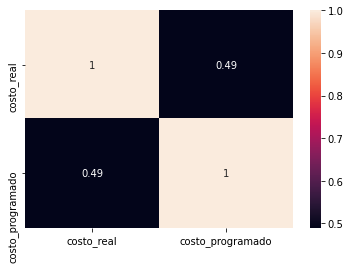

In [ ]:
# C) check correlation between variables 
corr_matrix = costo_marginal_clean[['costo_real','costo_programado']].corr()
sn.heatmap(corr_matrix, annot=True)

**Observations**: There is not a strong correlation between the actual cost and the forecasted cost. The cost that was forecasted does not follow the (linear) trend of the actual cost. This is for example, when the cost was scheduled to increase, the actual cost did not necessarily increase. 

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b16485e10>


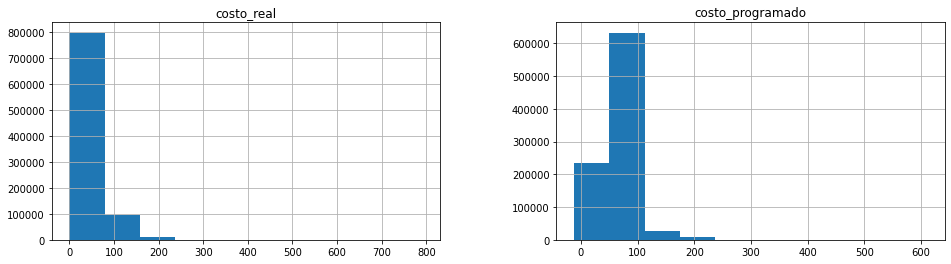

In [ ]:
# D) Check the data distribution
print(costo_marginal_clean[['costo_real','costo_programado']].hist(figsize=(16, 4)))

**Observation:** visually, the actual costs are mostly distributed between ~ 0 and ~ $ 80, while the costs that were forecasted are mostly distributed between ~ 50 and ~ 110 dollars 

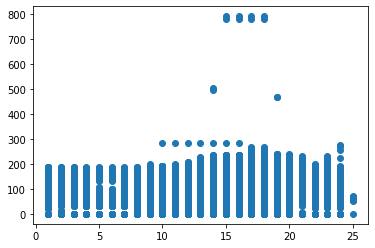

In [ ]:
# E) Check outliers 

# outliers en la variable costo real --> hora vs costo real
plt.scatter(costo_marginal_clean['hora'], costo_marginal_clean['costo_real'])
plt.show()

**Observation:**
there are very few outliers, the interesting thing is that they follow a pattern: for example, the outliers at the top are between the hours of 15 to 20, with a cost of around 800 dollars.

In [ ]:
# F) check missing values
costo_marginal_clean.isnull().sum()

Unnamed: 0                       0
barra_mnemotecnico               0
barra_referencia_mnemotecnico    0
fecha                            0
hora                             0
costo_real                       0
nombre                           0
costo_programado                 0
dtype: int64

**Observations:** There are not missing values

In [ ]:
# G) other

# Costo real por barra
costo_marginal_clean.groupby(costo_marginal_clean['barra_mnemotecnico'])['costo_real'].sum().sort_values() # group and sort

barra_mnemotecnico
BA01G049SE001G049         0.00
BA01T005SE284T005     87694.41
BA36T027SE067G216    109536.66
BA48T027SE123G216    112470.83
BA69T005SE281T005    113723.98
                       ...    
BA01T002SE031T002    381423.65
BA01T003SE001G041    383131.89
BA01T003SE032T003    385685.04
BA01T003SE005T003    398608.74
BA01T003SE015T003    406604.96
Name: costo_real, Length: 220, dtype: float64

**Observations:** There is a total of 220 energy stations 

In [ ]:
costo_marginal_clean.dtypes

Unnamed: 0                                int64
barra_mnemotecnico                       object
barra_referencia_mnemotecnico            object
fecha                            datetime64[ns]
hora                                      int64
costo_real                              float64
nombre                                   object
costo_programado                        float64
dtype: object

In [ ]:
# Costo real por mes
costo_marginal_clean['fecha'] = pd.to_datetime(costo_marginal_clean['fecha']) # 'fecha' as datetime data type
pd.DataFrame(costo_marginal_clean.groupby(costo_marginal_clean['fecha'].dt.strftime('%B'))['costo_real'].sum().sort_values()) # group and sort

,costo_real
fecha,
June,6105876.78
February,9044927.39
April,9269011.77
January,9363374.03
May,9403583.03
March,9573598.42


**Observations:** 
- The data is from January to June 2019 
- The actual cost seems to have a stable pattern in the first 5 months of the year but in June the cost is reduced drastically. 

<a name="cell-2."></a>
# **2. Feature engineering**

**2.1. Feature engineering**

In [ ]:
# create variable 'desviación'
costo_marginal_clean['desviacion'] = np.sqrt((costo_marginal_clean['costo_real'] - costo_marginal_clean['costo_programado'])**2)

# create variable 'desviacion_pct'
costo_marginal_clean['desviacion_pct'] = (costo_marginal_clean['desviacion'] / costo_marginal_clean['costo_programado'])*100

# create variable 'desviacion_cat'
costo_marginal_clean['desviacion_cat'] = 0
costo_marginal_clean.desviacion_cat[costo_marginal_clean.desviacion_pct > 15] = 1

costo_marginal_clean.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_real,nombre,costo_programado,desviacion,desviacion_pct,desviacion_cat
527903,BA66T005SE285T005,BA02T002SE032T002,2019-01-01,14,46.47,BA S/E CALAMA 110KV - BP1,47.996887,1.526887,3.181221,0
261503,BA02T002SE037T002,BA02T002SE032T002,2019-01-01,7,42.30,BA S/E TEMUCO 220KV SECCIÓN 1,42.337972,0.037972,0.089688,0
642018,BA69T005SE281T005,BA02T002SE032T002,2019-01-01,17,0.00,BA S/E CERRO DRAGÓN 110KV,50.376058,50.376058,100.000000,1
642017,BA46G216SE021G216,BA02T002SE032T002,2019-01-01,17,0.00,BA S/E ANTOFAGASTA 110KV BP1,46.451488,46.451488,100.000000,1
642016,BA21L108SE013L135,BA02T002SE032T002,2019-01-01,17,0.00,BA S/E A 100KV-BP1,48.659112,48.659112,100.000000,1


**2.2. Exploration of the variable that has the percentage of the cost deviation: 'desviacion_cat'**

In [ ]:
# percentage of the forecasted observations that has a cost deviation greater than 15% 
costo_marginal_clean['desviacion_cat'].value_counts()

0    666527
1    234402
Name: desviacion_cat, dtype: int64

In [ ]:
print('Percentage of the data that has a deviation greater than 15% :', round((234402/(666527+234402))*100,2),'% of the data')

Porcentaje de los datos que tienen una desviación mayor al 15% : 26.02 % de los datos


**Observations:** About a quarter of the observations have a deviation greater than 15% 

In [ ]:
# Behavior over the time of variable 'desviacion_cat'
pd.DataFrame(costo_marginal_clean.groupby(costo_marginal_clean['fecha'].dt.strftime('%B'))['desviacion_cat'].sum().sort_values(ascending=False))

,desviacion_cat
fecha,
February,49374
April,47758
January,46894
March,42417
May,36596
June,11363


**Observations:** In the first months of the semester, the number of cases that deviate more than 15% is stable, however, June shows a strong downward trend. Which means that the deviation is smaller, and therefore the forecasted costs begin to get closer to the actual ones. 

In [ ]:
# Energy stations that have most of the cases with higher deviation
pd.DataFrame(costo_marginal_clean.groupby(costo_marginal_clean['nombre'])['desviacion_cat'].sum().sort_values(ascending=False))

,desviacion_cat
nombre,
BA S/E NUEVA VENTANAS JB1,4345
BA S/E CHOLGUAN 220KV,2810
BA S/E DIEGO DE ALMAGRO 110KV B1,1957
BA S/E MAITENCILLO 110KV SECCIÓN1,1821
BA S/E PUNITAQUI 66KV,1558
...,...
BA S/E RANCAGUA 66KV B1,701
BA S/E CANUTILLAR JBP-A,673
BA S/E DON GOYO 220KV BP2,633


**Observations:** the enery station NUEVA VENTANAS JB1 has a significantly higher number of cases with deviation greater than 15%. It appears that it is more difficult to accurately forecast the costs of this bar. 

<a name="cell-3."></a>
# **3. Visualization**

**3.1. Create a function that plots the actual cost vs. the forecasted cost for an specific energy station and date**

In [ ]:
def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final,data):

    # select according to barra
    groups = data.groupby('barra_mnemotecnico') # group data according to barras
    selected_group = groups.get_group(codigo_barra) # get the barra
    selected_group['fecha'] = pd.to_datetime(selected_group['fecha']) # set fecha as datetime data type
    selected_group = selected_group.sort_values(['fecha','hora'],ascending=True) # sort

    # select according to date
    selected_group_and_date = selected_group.groupby([selected_group['fecha'].dt.strftime('%Y'),selected_group['fecha'].dt.strftime('%m'),selected_group['fecha'].dt.strftime('%d')])['costo_programado','costo_real'].sum() # group according to date, specifically according to day
    selected_group_and_date.index = selected_group_and_date.index.set_names(['año','mes','dia']) # change i=names of multiindex
    selected_group_and_date.reset_index(inplace=True) # set multiindex as column in the dataframe
    selected_group_and_date['fecha'] = pd.to_datetime(dict(year=selected_group_and_date.año, month=selected_group_and_date.mes, day=selected_group_and_date.dia), format='%m/%d/%y') # create año, mes and día variables and set them as datetime data type
    selected_group_and_date = selected_group_and_date[(selected_group_and_date.fecha >= fecha_inicial) & (selected_group_and_date.fecha <= fecha_final)] # select cases between fecha_inicial and fecha_final
    selected_group_and_date.index = selected_group_and_date['fecha'] # set fecha as index

    # visualize
    color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"] # some design
    plt.style.use('fivethirtyeight')
    selected_group_and_date[['costo_programado', 'costo_real']].plot(figsize=(15, 5))

    return

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


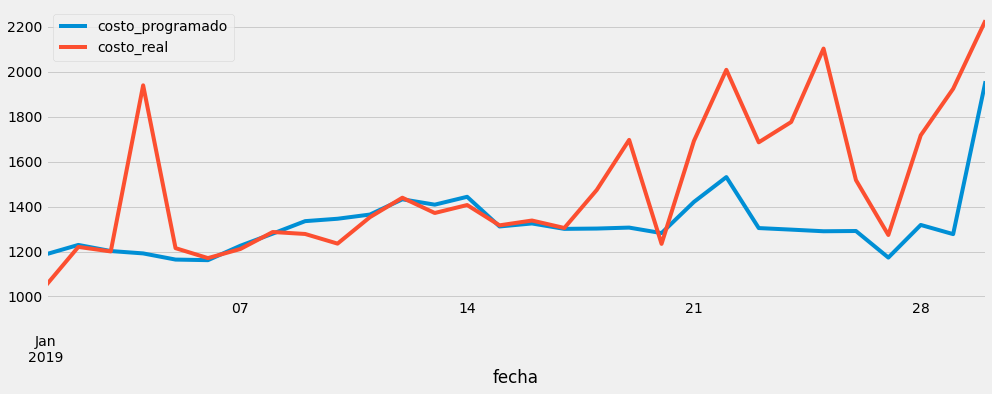

In [ ]:
# Example
time_plot_costo_barra('BA01G004SE001T011','2019/01/01','2019/01/30',costo_marginal_clean)

**Observation:** there is no clear pattern that can be distinguished. Seasonality cannot be detected because there is no precise amount of time between peaks. However, there could be a pattern according to the month of the year, however, we would need data from previous years to compare and confirm this. 

<a name="cell-4."></a>
# **4. Add more variables that can help to build a better prediction model**

**4.1. Upload data**

In [ ]:
# Upload data

# invoke a file selector (select the files)
from google.colab import files

uploaded = files.upload()

# iterate the uploaded files in order to find their key names
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving base_para_prediccion.csv to base_para_prediccion.csv
User uploaded file "base_para_prediccion.csv" with length 10782529 bytes


About the variables:
- ID of the energy station: nemotecnico_se
- date: fecha
- time: hora
- wind energy: gen_eolica_total_mwh
- geothermical energy: geo_geotermica_total_mwh
- hydraulic energy: geo_hidraulica_total_mwh
- solar energy: gen_solar_total_mwh
- thermal energy: geo_termica_total_mwh
- actual cost: cmg_real
- forecasted cost: cmg_prog
- cost deviation (forecasted-actual): cmg_desv
- porcentual deviation: cmg_desv_pct
- number of energy stations: n_barras
- demand (megawatt hour of energy): demanda_mwh
- capacity to generate energy: cap_inst_mw

In [ ]:
base_prediccion = pd.read_csv('base_para_prediccion.csv')
base_prediccion.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00 UTC,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785


**4.2. Explore data**

In [ ]:
# A) descriptive statistics
pd.DataFrame(base_prediccion.describe())

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
mean,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500
max,25.000000,NaN,NaN,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800


In [ ]:
# B) Check missing values
base_prediccion.isnull().sum()

nemotecnico_se                   0
fecha                            0
hora                             0
gen_eolica_total_mwh        112779
gen_geotermica_total_mwh    112779
gen_hidraulica_total_mwh     78595
gen_solar_total_mwh          70961
gen_termica_total_mwh        50916
cmg_real                         0
cmg_prog                         0
cmg_desv                         0
cmg_desv_pct                     0
n_barras                         0
demanda_mwh                      0
cap_inst_mw                      0
dtype: int64

**Observations:**
- All observations in tha variables wind energy and geothermal energy are missing
- There is a considerable amount of missing values for hydro, solar and thermal generated energy, 70%, 63% and 45% of the data are missing values (respectively) 

In [ ]:
# C) Count the number of cases that a type of energy generated zero mwh's
(base_prediccion == 0).sum()

nemotecnico_se                  0
fecha                           0
hora                            0
gen_eolica_total_mwh            0
gen_geotermica_total_mwh        0
gen_hidraulica_total_mwh     5586
gen_solar_total_mwh         22716
gen_termica_total_mwh       32104
cmg_real                     1212
cmg_prog                        1
cmg_desv                      168
cmg_desv_pct                  164
n_barras                        0
demanda_mwh                  8257
cap_inst_mw                     0
dtype: int64

**Observations:** 
- The "solar" and "thermal" types of energy have a high number of cases where they generated zero mwh's. About 30% of the data for thermal energy is zero, and about 20% of the data for solar energy is zero
- The time period covered by the database is from January to June 2019 


**4.3. Feature engineering**

In [ ]:
# Create variable year 
base_prediccion['fecha'] = pd.to_datetime(base_prediccion['fecha']) # convret to datetime data type
base_prediccion = base_prediccion.sort_values(['nemotecnico_se','fecha','hora'],ascending=True) # sort
base_prediccion['año'] = pd.DatetimeIndex(base_prediccion['fecha']).year
# Create variable month
base_prediccion['mes'] = pd.DatetimeIndex(base_prediccion['fecha']).month
# Create variable week
base_prediccion['semana'] = pd.DatetimeIndex(base_prediccion['fecha']).week
# Create variable day
base_prediccion['day'] = pd.DatetimeIndex(base_prediccion['fecha']).day # números de 0 a 6
# Create variable day of the week
base_prediccion['dia_semana'] = pd.DatetimeIndex(base_prediccion['fecha']).dayofweek
# Create variable that indicates whether it is weekday or weekend
base_prediccion['semana_findesemana'] = ((pd.DatetimeIndex(base_prediccion['fecha']).dayofweek) // 5 == 1).astype(float) # 0 if weekday, 1 if weekend

base_prediccion.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,semana,day,dia_semana,semana_findesemana
120,SE001T002,2019-01-01 00:00:00+00:00,1,NaN,NaN,NaN,0.0,0.0,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,2019,1,1,1,1,0.0
121,SE001T002,2019-01-01 00:00:00+00:00,2,NaN,NaN,NaN,0.0,0.0,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,2019,1,1,1,1,0.0
122,SE001T002,2019-01-01 00:00:00+00:00,3,NaN,NaN,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,1,1,1,0.0
123,SE001T002,2019-01-01 00:00:00+00:00,4,NaN,NaN,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,1,1,1,0.0
124,SE001T002,2019-01-01 00:00:00+00:00,5,NaN,NaN,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,1,1,1,0.0


**4.4. Create a function that visualizes the energy generated in a specific energy station according to a specific type of energy in certain days**

In [ ]:
def produccion_energia_diaria_subestacion(codigo_subestacion,var_tipo_de_energia,lista_fechas,data):

    data['fecha'] = pd.to_datetime(data['fecha'])  # set fechas as datetime data type

    for fecha in lista_fechas:

        # select according to subestacion and date
        selected_subestacion_fecha = data[(data['nemotecnico_se'] == codigo_subestacion) & (data['fecha'] == fecha)]
        selected_subestacion_fecha.index = selected_subestacion_fecha['hora']

        # visualize
        color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"] # some design
        plt.style.use('fivethirtyeight')
        plt.plot(selected_subestacion_fecha['hora'],selected_subestacion_fecha[var_tipo_de_energia],label=fecha)
        plt.show()

    return


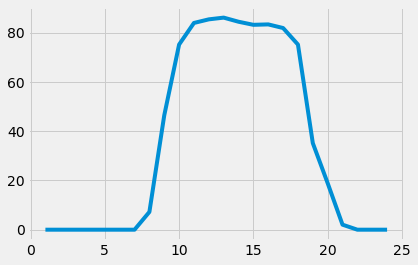

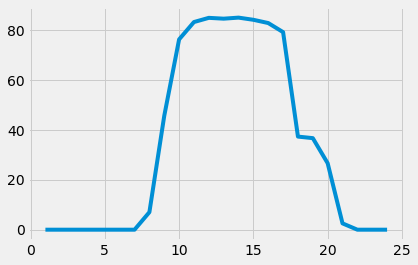

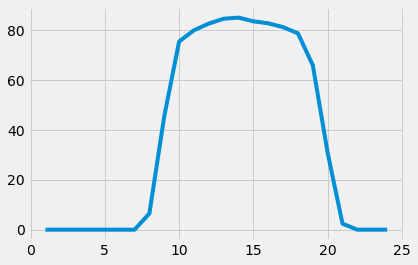

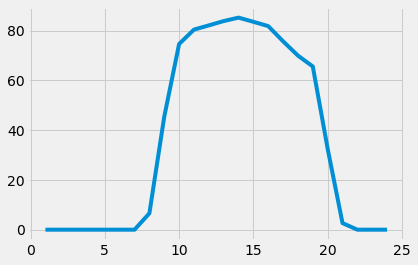

In [ ]:
# Example: Subestacion SE005T002
produccion_energia_diaria_subestacion('SE005T002','gen_solar_total_mwh',['2019/01/11','2019/01/12','2019/01/13','2019/01/14'],base_prediccion)

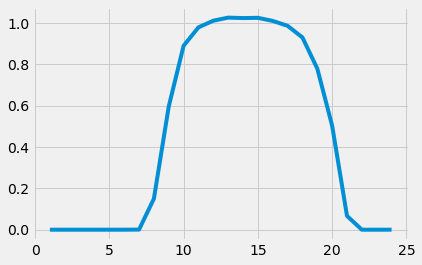

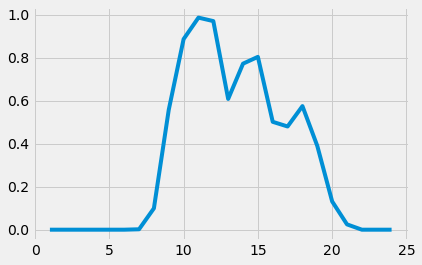

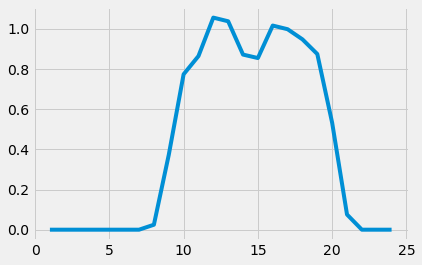

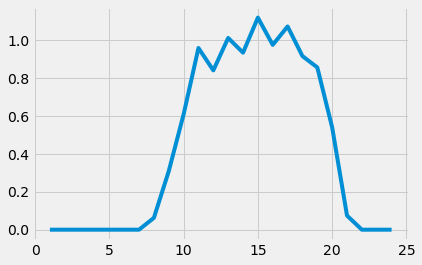

In [ ]:
# Example: energy station SE127T005
produccion_energia_diaria_subestacion('SE127T005','gen_solar_total_mwh',['2019/01/11','2019/01/12','2019/01/13','2019/01/14'],base_prediccion)

<a name="cell-5."></a>
# **5. Predict whether the there will be a deviation greater than 15% on the forecasted cost**

**Notas:** 
- The model used is "extreme gradient boosted decision trees" through the XGBoost library
- This is a classification problem, where 0 is predicted if the deviation is less than 15% and 1 is predicted if the deviation is greater than 15%"
- To avoid data leakage, the variables with which the target variable was built are discarded from the model (actual cost, forecasted cost, and porcentage of deviation)

**5.1. Feature engineering**


In [ ]:
# A) Create a variable that identifies if the deviation is greater than 15%
base_prediccion['cmg_desv_pct'] = np.sqrt(base_prediccion['cmg_desv_pct']**2)
base_prediccion['cmg_desv_cat'] = 0 # create variable
base_prediccion.cmg_desv_cat[base_prediccion.cmg_desv_pct > 15] = 1 # 1 if it is grester than 15%

# B) Create feature: total energy generation (sum of the types of energy)
# check if there are cases where all types of energy are nan's
len(base_prediccion[(base_prediccion['gen_hidraulica_total_mwh'] == np.nan) & (base_prediccion['gen_solar_total_mwh'] == np.nan) & (base_prediccion['gen_termica_total_mwh'] == np.nan)]) 
# sum up (for summing up, we'll consider nan's as zero)
base_prediccion['en_total_mwh'] = base_prediccion['gen_hidraulica_total_mwh'].fillna(0) + base_prediccion['gen_solar_total_mwh'].fillna(0) + base_prediccion['gen_termica_total_mwh'].fillna(0) 

# C) Lag: add as a feature the desv_cat of the day before
lag_desv_cat_del_dia_anterior = base_prediccion.iloc[24:,:]
lag_desv_cat_del_dia_anterior = lag_desv_cat_del_dia_anterior.reset_index(drop=True)
lag_desv_cat_del_dia_anterior = lag_desv_cat_del_dia_anterior['cmg_desv_cat'] # el método para añadir el lag no es preciso 100% pero se acerca bastante a la idea
base_prediccion = base_prediccion.iloc[:-24,:]
base_prediccion = base_prediccion.reset_index(drop=True)
base_prediccion['lag_desv_cat_del_dia_anterior'] = lag_desv_cat_del_dia_anterior

# D) Set the names of the subestaciones (nemotecnico_se) as numbers
base_prediccion['nemotecnico_se2'] = base_prediccion['nemotecnico_se'].astype('category') # set as category data type
base_prediccion['nemotecnico_se2'] = base_prediccion['nemotecnico_se2'].cat.codes # from categories to numbers

base_prediccion.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,semana,day,dia_semana,semana_findesemana,cmg_desv_cat,en_total_mwh,lag_desv_cat_del_dia_anterior,nemotecnico_se2
0,SE001T002,2019-01-01 00:00:00+00:00,1,NaN,NaN,NaN,0.0,0.0,54.03,124.604410,-70.57,56.64,2,61148556,14.2881,2019,1,1,1,1,0.0,1,0.0,0,0
1,SE001T002,2019-01-01 00:00:00+00:00,2,NaN,NaN,NaN,0.0,0.0,54.03,125.415516,-71.39,56.92,2,136880002,14.2881,2019,1,1,1,1,0.0,1,0.0,0,0
2,SE001T002,2019-01-01 00:00:00+00:00,3,NaN,NaN,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,1,1,1,0.0,0,0.0,0,0
3,SE001T002,2019-01-01 00:00:00+00:00,4,NaN,NaN,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,1,1,1,0.0,0,0.0,1,0
4,SE001T002,2019-01-01 00:00:00+00:00,5,NaN,NaN,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,1,1,1,0.0,0,0.0,1,0


**5.3. Build the model**

In [ ]:
# A) Split train and test data
msk = np.random.rand(len(base_prediccion)) < 0.8
data_train = base_prediccion[msk]
data_test = base_prediccion[~msk]

# B) Identify independent variables
X_train = data_train[['nemotecnico_se2','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh',
                      'n_barras','demanda_mwh','cap_inst_mw','año','mes','semana','day','dia_semana',
                      'semana_findesemana','en_total_mwh','lag_desv_cat_del_dia_anterior']]

X_test = data_test[['nemotecnico_se2','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh',
                    'n_barras','demanda_mwh','cap_inst_mw','año','mes','semana','day','dia_semana',
                    'semana_findesemana','en_total_mwh','lag_desv_cat_del_dia_anterior']]

# C) Identify the dependent variable (labels)
y_train = data_train['cmg_desv_cat']
y_test = data_test['cmg_desv_cat']

# D) Build XGBoost model and train it
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

[09:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.483676	validation_1-rmse:0.48354
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.470016	validation_1-rmse:0.469777
[2]	validation_0-rmse:0.458522	validation_1-rmse:0.458176
[3]	validation_0-rmse:0.448952	validation_1-rmse:0.448583
[4]	validation_0-rmse:0.441018	validation_1-rmse:0.440581
[5]	validation_0-rmse:0.434441	validation_1-rmse:0.433912
[6]	validation_0-rmse:0.428939	validation_1-rmse:0.428374
[7]	validation_0-rmse:0.42433	validation_1-rmse:0.423775
[8]	validation_0-rmse:0.420539	validation_1-rmse:0.419981
[9]	validation_0-rmse:0.417252	validation_1-rmse:0.416745
[10]	validation_0-rmse:0.41454	validation_1-rmse:0.414102
[11]	validation_0-rmse:0.412279	validation_1-rmse:0.411798
[12]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# E) Model evaluation

# Get prediction on validation set
y_pred = reg.predict(X_test)

# Confusion matrix
cm = confusion_matrix((y_pred > 0.5), y_test)
cm

array([[16032,  3387],
       [  767,  2327]])

In [ ]:
# Calculate the accuracy on test set
predict_accuracy_on_test_set = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[1, 1] + cm[1, 0] + cm[0, 1])
print('The Accuracy on Test Set is: ', predict_accuracy_on_test_set)

The Accuracy on Test Set is:  0.8154843867987385


In [ ]:
# calculate Precision
precision = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print('The Precision on Test Set is: ', precision)

The Precision on Test Set is:  0.7521008403361344


In [ ]:
# Calculate Recall
recall = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print('The Recall on Test Set is: ', recall)

The Recall on Test Set is:  0.4072453622681134


**Observations:**
- Precision: 75% -> of the observations classified as "deviation greater than 15%", 75% were correctly classified
- Recall: 41% -> of the total observations in the class "deviation greater than 15%", only 41% were classified correctly. In part, it may be due to the imbalance in the data, since there are ~3 times more observations in the class "deviation less than 15%" than in the class "deviation greater than 15%", so the model cannot learn enough about this class. 

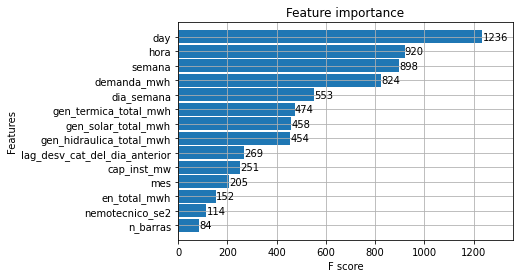

In [ ]:
# F) Plot feature importance
plot_importance(reg, height=0.9)

**Observations:** 
The variables related to the time, week, and demand are the main variable that influence the decisions that the algorithm makes.
